<a href="https://colab.research.google.com/github/EnalSingh/EnalSingh/blob/main/Tourism_trend_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install pandas matplotlib scikit-learn prophet meteostat pytrends --quiet


In [19]:
import pandas as pd
import numpy as np

# Monthly dates
date_range = pd.date_range(start="2015-01-01", end="2024-12-01", freq="MS")

# Simulated tourist arrivals
np.random.seed(42)
arrivals = (10000 +
            500 * np.sin(2 * np.pi * date_range.month / 12) +  # yearly seasonality
            300 * (date_range.year - 2015) +                   # growth
            np.random.normal(0, 500, len(date_range)))         # noise

# Add synthetic "weather" (avg temp) and "search index"
weather_temp = 20 + 10 * np.sin(2 * np.pi * date_range.month / 12) + np.random.normal(0, 2, len(date_range))
search_index = 50 + 20 * np.sin(2 * np.pi * date_range.month / 12) + (date_range.year - 2015) * 2 + np.random.normal(0, 5, len(date_range))

# Build DataFrame
df = pd.DataFrame({
    "ds": date_range,
    "y": arrivals.astype(int),
    "temp": weather_temp,
    "search_index": search_index
})

# Save dataset
df.to_csv("tourism.csv", index=False)

print("✅ Sample dataset created with extra features: tourism.csv")
print(df.head(12))


✅ Sample dataset created with extra features: tourism.csv
           ds      y       temp  search_index
0  2015-01-01  10498  26.582064     56.037396
1  2015-02-01  10363  26.841479     66.746826
2  2015-03-01  10823  32.805589     72.524936
3  2015-04-01  11194  25.856552     71.649284
4  2015-05-01  10132  26.173714     53.998518
5  2015-06-01   9882  24.380911     48.327494
6  2015-07-01  10539  13.018927     37.625273
7  2015-08-01   9950  10.207151     29.412846
8  2015-09-01   9265  10.199303     38.827271
9  2015-10-01   9838  10.332795     34.704400
10 2015-11-01   9518  11.898673     33.695580
11 2015-12-01   9767  20.137126     54.589310


In [20]:
df = pd.read_csv("tourism.csv")
df['ds'] = pd.to_datetime(df['ds'])
df.head()


,ds,y,temp,search_index
0,2015-01-01,10498,26.582064,56.037396
1,2015-02-01,10363,26.841479,66.746826
2,2015-03-01,10823,32.805589,72.524936
3,2015-04-01,11194,25.856552,71.649284
4,2015-05-01,10132,26.173714,53.998518


In [21]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Train until end of 2022, test on 2023–2024
train = df[df['ds'] < "2023-01-01"]
test = df[df['ds'] >= "2023-01-01"]

# Model with extra features (regressors)
m = Prophet(yearly_seasonality=True)
m.add_regressor("temp")
m.add_regressor("search_index")

# Fit
m.fit(train)

# Forecast on test period
future = test[["ds", "temp", "search_index"]]
forecast = m.predict(future)

# Evaluate
y_true = test["y"].values
y_pred = forecast["yhat"].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("📊 Accuracy on Test Data (2023–2024)")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpemrbdmzd/6kz93uvc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpemrbdmzd/vkvc7abd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87280', 'data', 'file=/tmp/tmpemrbdmzd/6kz93uvc.json', 'init=/tmp/tmpemrbdmzd/vkvc7abd.json', 'output', 'file=/tmp/tmpemrbdmzd/prophet_modelr2dhbepy/prophet_model-20251003080458.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:04:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:04:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📊 Accuracy on Test Data (2023–2024)
MAE  : 393.78
RMSE : 486.49
MAPE : 3.10%


In [22]:
# Retrain on full dataset
m_full = Prophet(yearly_seasonality=True)
m_full.add_regressor("temp")
m_full.add_regressor("search_index")

m_full.fit(df)

# Create future dataframe with regressors
future_full = df[["ds", "temp", "search_index"]].copy()
extra_future = pd.date_range(start="2025-01-01", end="2025-12-01", freq="MS")

# Simulate future weather & search index
future_temp = 20 + 10 * np.sin(2 * np.pi * extra_future.month / 12) + np.random.normal(0, 2, len(extra_future))
future_search = 50 + 20 * np.sin(2 * np.pi * extra_future.month / 12) + (extra_future.year - 2015) * 2 + np.random.normal(0, 5, len(extra_future))

extra_df = pd.DataFrame({
    "ds": extra_future,
    "temp": future_temp,
    "search_index": future_search
})

future_all = pd.concat([future_full, extra_df])

# Forecast
forecast_full = m_full.predict(future_all)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpemrbdmzd/6ec3spbl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpemrbdmzd/monj_w3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1819', 'data', 'file=/tmp/tmpemrbdmzd/6ec3spbl.json', 'init=/tmp/tmpemrbdmzd/monj_w3z.json', 'output', 'file=/tmp/tmpemrbdmzd/prophet_model1w03seu_/prophet_model-20251003080459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:04:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:04:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


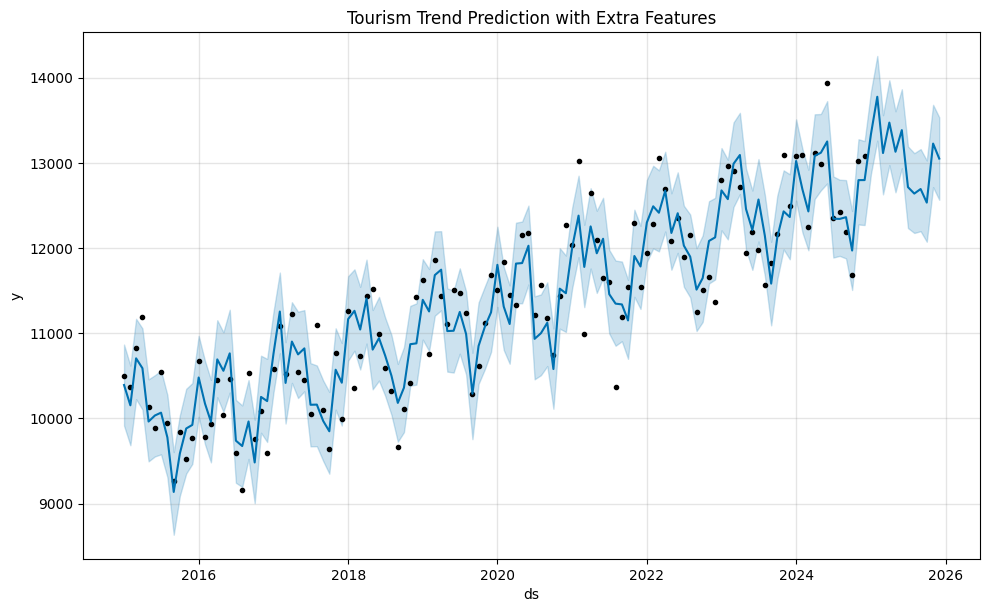

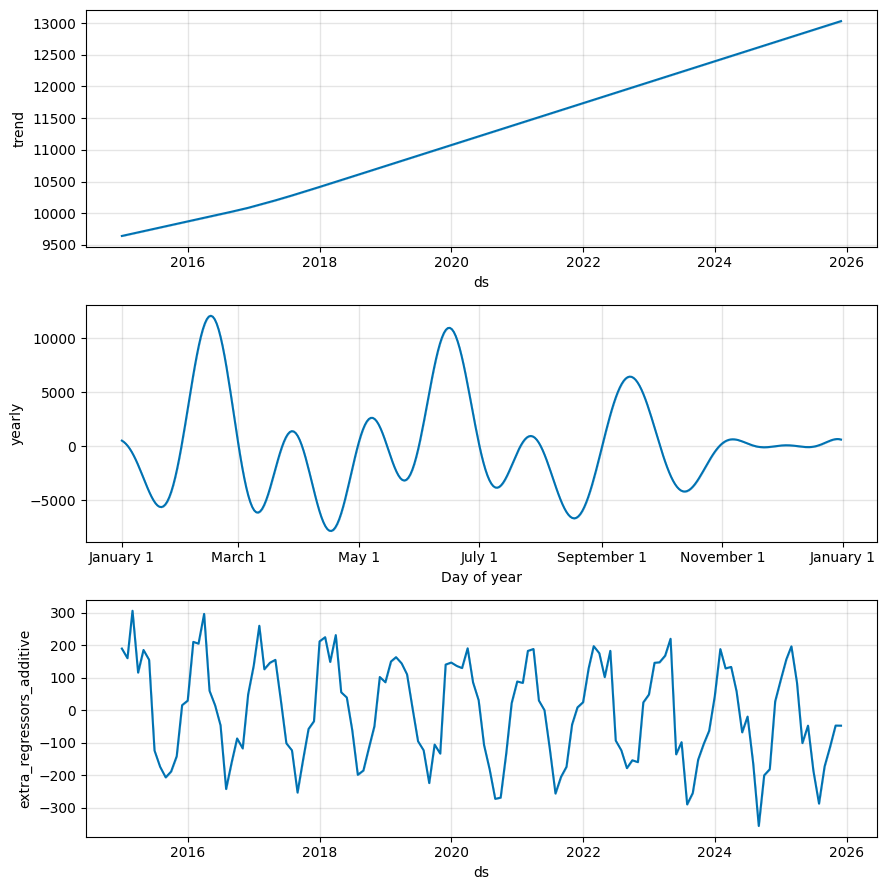

In [23]:
import matplotlib.pyplot as plt

# Plot forecast
m_full.plot(forecast_full)
plt.title("Tourism Trend Prediction with Extra Features")
plt.show()

# Show components
m_full.plot_components(forecast_full)
plt.show()


In [24]:
forecast_full[['ds','yhat','yhat_lower','yhat_upper']].to_csv('tourism_forecast.csv', index=False)

from google.colab import files
files.download('tourism_forecast.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# Split into train (till 2022) and test (2023–2024)
train = df[df['ds'] < "2023-01-01"]
test = df[df['ds'] >= "2023-01-01"]

print("Train size:", len(train))
print("Test size:", len(test))


Train size: 96
Test size: 24


In [26]:
m_train = Prophet(yearly_seasonality=True)
m_train.fit(train)

future_test = m_train.make_future_dataframe(periods=len(test), freq="MS")
forecast_test = m_train.predict(future_test)

# Compare predicted vs actual
compare = forecast_test[['ds','yhat']].merge(test, on='ds')
compare.head()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpemrbdmzd/x81mbrqr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpemrbdmzd/k84e3e9v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16772', 'data', 'file=/tmp/tmpemrbdmzd/x81mbrqr.json', 'init=/tmp/tmpemrbdmzd/k84e3e9v.json', 'output', 'file=/tmp/tmpemrbdmzd/prophet_modelcuu7bf1l/prophet_model-20251003080501.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:05:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:05:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,y,temp,search_index
0,2023-01-01,12633.182125,12798,23.454350,71.872514
1,2023-02-01,12361.795034,12963,28.186617,81.713579
2,2023-03-01,12924.512905,12902,29.029273,88.064657
3,2023-04-01,13011.026681,12715,28.824002,80.501885
4,2023-05-01,12310.063340,11942,29.629317,71.888898


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

rmse = np.sqrt(mean_squared_error(compare['y'], compare['yhat']))
mape = mean_absolute_percentage_error(compare['y'], compare['yhat']) * 100

print("📊 Accuracy Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


📊 Accuracy Metrics:
RMSE: 446.96
MAPE: 2.80%


In [28]:
# Add Average Temperature (°C) and Google Search Index (0–100)
np.random.seed(42)
df['avg_temp'] = 20 + 10 * np.sin(2*np.pi*df['ds'].dt.month/12) + np.random.normal(0,1,len(df))
df['search_index'] = 50 + 30 * np.sin(2*np.pi*df['ds'].dt.month/12) + np.random.normal(0,5,len(df))

# Display sample
df.head()


,ds,y,temp,search_index,avg_temp
0,2015-01-01,10498,26.582064,68.955160,25.496714
1,2015-02-01,10363,26.841479,71.433825,28.521990
2,2015-03-01,10823,32.805589,87.013972,30.647689
3,2015-04-01,11194,25.856552,68.971507,30.183284
4,2015-05-01,10132,26.173714,67.934285,24.765847


from matplotlib import pyplot as plt
_df_0['y'].plot(kind='hist', bins=20, title='y')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['temp'].plot(kind='hist', bins=20, title='temp')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['search_index'].plot(kind='hist', bins=20, title='search_index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['avg_temp'].plot(kind='hist', bins=20, title='avg_temp')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='y', y='temp', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='temp', y='search_index', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='search_index', y='avg_temp', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['y']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('y')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['temp']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('temp')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['search_index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('search_index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['avg_temp']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('avg_temp')

from matplotlib import pyplot as plt
_df_11['y'].plot(kind='line', figsize=(8, 4), title='y')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['temp'].plot(kind='line', figsize=(8, 4), title='temp')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['search_index'].plot(kind='line', figsize=(8, 4), title='search_index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['avg_temp'].plot(kind='line', figsize=(8, 4), title='avg_temp')
plt.gca().spines[['top', 'right']].set_visible(False)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpemrbdmzd/yrbc9nkf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpemrbdmzd/1gg9ai_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14038', 'data', 'file=/tmp/tmpemrbdmzd/yrbc9nkf.json', 'init=/tmp/tmpemrbdmzd/1gg9ai_4.json', 'output', 'file=/tmp/tmpemrbdmzd/prophet_modelwnzjiw25/prophet_model-20251003080502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:05:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:05:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


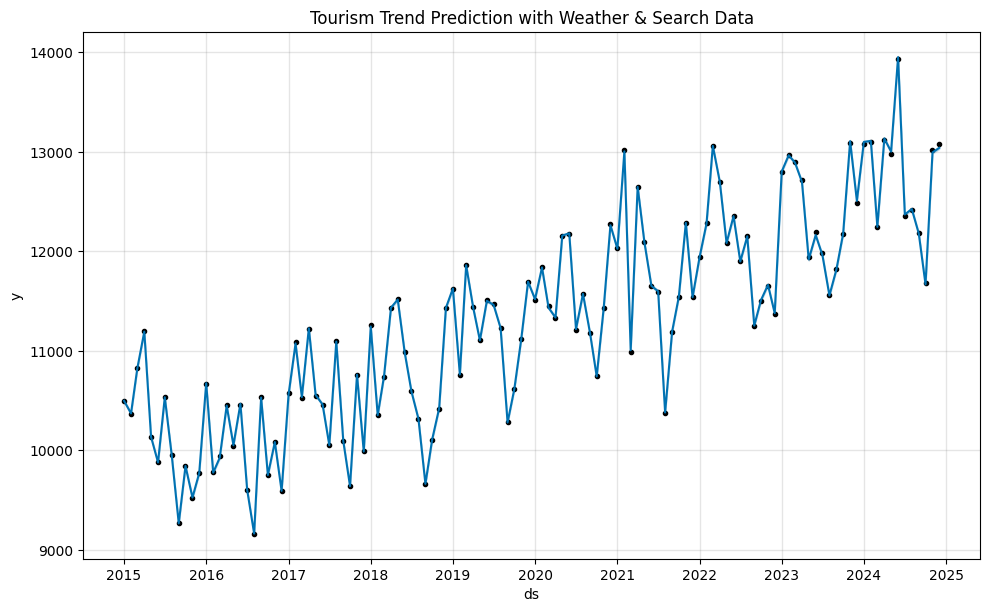

In [29]:
m_extra = Prophet(yearly_seasonality=True)
m_extra.add_regressor('avg_temp')
m_extra.add_regressor('search_index')

m_extra.fit(df)

future_extra = df[['ds','avg_temp','search_index']]
forecast_extra = m_extra.predict(future_extra)

# Plot with extra features
m_extra.plot(forecast_extra)
plt.title("Tourism Trend Prediction with Weather & Search Data")
plt.show()


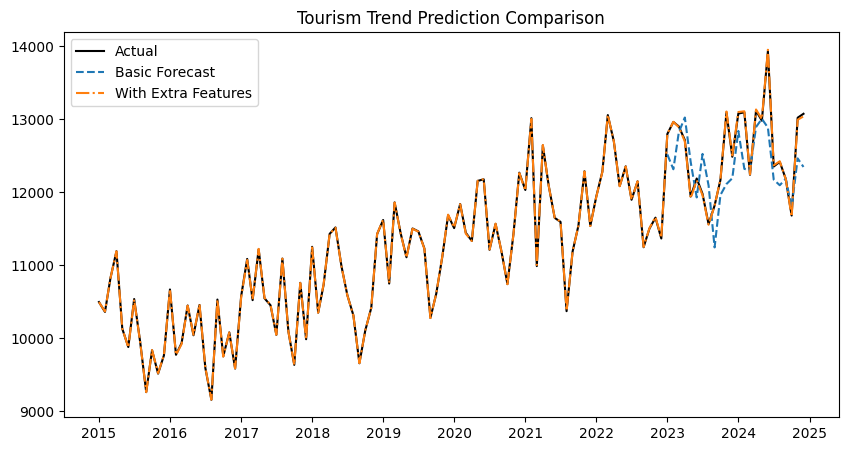

In [30]:
plt.figure(figsize=(10,5))
plt.plot(df['ds'], df['y'], label="Actual", color="black")
plt.plot(forecast['ds'], forecast['yhat'], label="Basic Forecast", linestyle="--")
plt.plot(forecast_extra['ds'], forecast_extra['yhat'], label="With Extra Features", linestyle="-.")
plt.legend()
plt.title("Tourism Trend Prediction Comparison")
plt.show()


In [31]:
!pip install prophet python-docx --quiet
